## 2-2. 나만의 YOLO 모델 생성
- 검은색 바탕에 간단한 도형 3개만 탐지하는 YOLO 모델
- 가로, 세로 3개의 셀로 나누는 방식으로 문제 단순화
- 한 셀 당 1개의 박스를 그리는 방식으로 수정
- Class도 3개로 줄여 구현


In [7]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 파라미터 설정

# 이미지 크기
width_size = 256
height_size = 256
channel_size = 3
img_size = (width_size, height_size, channel_size)
# 이미지를 나눌 크기
cell_num = 3
# 찾고자 하는 객체 개수
class_num = 3
# 한 셀에 그릴 박스 수
anchor_num = 1
label_num = anchor_num * (5 + class_num)
# 학습 수
epoch_num = 20000
# 로스 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 0.5

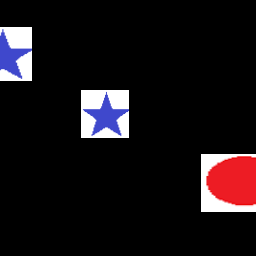

In [2]:
# 랜덤하게 도형을 그리고, 실제 정답 값을 생성하는 함수 정의
# 0.png, 1.png, 2.png 필요(https://github.com/lovedlim/tensorflow/tree/main/Part%204)
def make_img_label():
    img = np.zeros((height_size+400, width_size+400, channel_size))
    label = np.zeros((cell_num, cell_num, label_num))
    num_shape = np.random.randint(1, 4)
    i = np.random.choice(range(cell_num), num_shape, replace=False)
    j = np.random.choice(range(cell_num), num_shape, replace=False)

    img_0 = cv2.imread('0.png')
    img_1 = cv2.imread('1.png')
    img_2 = cv2.imread('2.png')

    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        shape_type = np.random.randint(0, class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 + 0.1
        h_rate = np.random.rand() * 0.3 + 0.1

        label[row, col] = [1, x_rate, y_rate, w_rate, h_rate, 0, 0, 0]
        label[row, col, 5+shape_type] = 1
        x = int(x_rate * width_size/cell_num + col * width_size/cell_num)
        y = int(y_rate * height_size/cell_num + row * height_size/cell_num)
        w = int(w_rate * width_size/2) * 2
        h = int(h_rate * height_size/2) * 2
        if(shape_type==0):
            input_img = cv2.resize(img_0, (w, h))
        if(shape_type==1):
            input_img = cv2.resize(img_1, (w, h))
        if(shape_type==2):
            input_img = cv2.resize(img_2, (w, h))
        img[y-int(h/2)+200: y+int(h/2)+200, x-int(w/2)+200: x+int(w/2)+200] = input_img
    img = img[200: 200+height_size, 200: 200+width_size]
    return img, label

img, label = make_img_label()
cv2_imshow(img)

- 3개의 이미지 파일 사용
- cv2를 이용해 랜덤 위치에 3개의 도형 이미지 그리기
- 해당 이미지 위치를 찾아 경계 박스로 나타내고 정답 클래스 레이블까지 반환하는 함수 정의

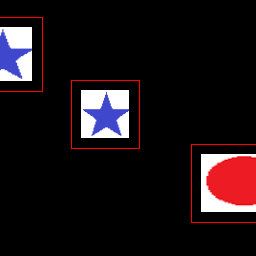

In [5]:
# 이미지와 정답(혹은 예측 값)을 넣으면 박스를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th 이상일 때만 박스 생성)
def show_box(img, label, th=0.3):
    b_img = np.zeros((height_size+400, width_size+400, 3))
    b_img[200:200+height_size, 200:200+width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if label[i, j, 0] > th:
                x_rate = label[i, j, 1]
                y_rate = label[i, j, 2]
                w_rate = label[i, j, 3]
                h_rate = label[i, j, 4]
                shape_type = np.argmax(label[i, j, :5])
                if shape_type == 0:
                    line_color = [0, 0, 255]
                if shape_type == 1:
                    line_color = [255, 0, 0]
                if shape_type == 2:
                    line_color = [0, 255, 0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * height_size/3 + i * width_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * height_size/2) * 2 + 20
                cv2.rectangle(b_img, (x-int(w/2)+200, y-int(h/2)+200), (x+int(w/2)+200, y+int(h/2)+200), line_color)

    b_img = b_img[200:200+height_size, 200:200+width_size]
    return b_img
cv2_imshow(show_box(img, label))

- 앞에서 생성한 이미지와 클래스를 입력하면 탐지한 이미지에 박스를 그려주는 함수 정의
- 논문에서 구현한 NMS(Non-Maximum Suppresion)은 여기서 적용X
    - NMS란 서로 다른 두 박스가 하나의 객체를 탐지할 경우 예측 확률이 낮은 박스는 지우는 알고리즘
    - 따라서 예제는 특정 도형 이미지를 탐지한 모든 경계 박스가 표시

In [8]:
# VGG16 모델을 베이스로 마지막 부분만 수정하는 모델 생성(전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top=False, input_shape=img_size)
vgg_model.trainable=False
i = tf.keras.Input(shape=img_size)
out = tf.keras.layers.Lambda((lambda x: x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256, 3, padding='same')(out)
out = tf.keras.layers.Conv2D(128, 3, padding='same')(out)
out = tf.keras.layers.Conv2D(64, 3, padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024, activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8, activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3, 3, 8))(out)
yolo_model = tf.keras.Model(inputs=[i], outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
______________________________________________________________

- 객체 탐지 모델의 성능이 어느 정도 나오기 위해서는 복잡한 구조로 구현되어야 함
    - 전이 학습을 사용(VGG16)

In [12]:
# 학습 과정을 동영상으로 기록
fcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('yolo.avi', fcc, 1.0, (width_size, height_size))
for e in range(epoch_num):
    img, label = make_img_label()
    img = np.reshape(img, (1, height_size, width_size, 3))
    label = np.reshape(label, (1, 3, 3, 8))
    loss_p_list = []
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)
        # 이미지를 구분한 셀을 탐험
        for i in range(3):
            for j in range(3):
                # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
                if label[0, i, j, 0] == 1:
                    loss_p_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
                    loss_cod_list.append(tf.square(label[0, i, j, 1] - pred[0, i, j, 1]))
                    loss_cod_list.append(tf.square(label[0, i, j, 2] - pred[0, i, j, 2]))
                    loss_cod_list.append(tf.square(label[0, i, j, 3] - pred[0, i, j, 3]))
                    loss_cod_list.append(tf.square(label[0, i, j, 4] - pred[0, i, j, 4]))
                    loss_c_list.append(tf.square(label[0, i, j, 5] - pred[0, i, j, 5]))
                    loss_c_list.append(tf.square(label[0, i, j, 6] - pred[0, i, j, 6]))
                    loss_c_list.append(tf.square(label[0, i, j, 7] - pred[0, i, j, 7]))
                # 해당 셀에 객체가 없을 경우 객체가 없을 확률만 Loss로 계산
                else:
                    loss_p_no_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
        loss_p = tf.reduce_mean(loss_p_list)
        loss_cod = tf.reduce_mean(loss_cod_list)
        loss_c = tf.reduce_mean(loss_c_list)
        loss_p_no = tf.reduce_mean(loss_p_no_list)
        # 각 Loss를 비중을 곱해 최종 로스를 계산
        loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no
    #Loss에 대한 Grad를 구하고, 각 파라미터 업데이트
    vars = yolo_model.trainable_variables
    grad = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grad, vars))
    # 100번마다 동영상에 이미지를 기록
    if e % 100 == 0:
        img = np.reshape(img, (256, 256, 3))
        label = pred.numpy()
        label = np.reshape(label, (3, 3, 8))
        sample_img = np.uint8(show_box(img, label))
        out.write(sample_img)
    print(e, '완료', loss.numpy())
out.release()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15000 완료 0.010524827
15001 완료 0.09817889
15002 완료 0.05386927
15003 완료 0.018982567
15004 완료 0.031155787
15005 완료 0.029598305
15006 완료 0.25814497
15007 완료 0.005925881
15008 완료 0.003687177
15009 완료 0.00907649
15010 완료 0.015494415
15011 완료 0.01455405
15012 완료 0.045415875
15013 완료 0.014950322
15014 완료 0.041215222
15015 완료 0.02903805
15016 완료 0.008676751
15017 완료 0.023302283
15018 완료 0.010136866
15019 완료 0.043046165
15020 완료 0.033608705
15021 완료 0.049531024
15022 완료 0.013916657
15023 완료 0.05516729
15024 완료 0.05898484
15025 완료 0.06140109
15026 완료 0.15725861
15027 완료 0.005694711
15028 완료 0.02076558
15029 완료 0.04781306
15030 완료 0.025524367
15031 완료 0.02620545
15032 완료 0.021108095
15033 완료 0.0048725232
15034 완료 0.12535505
15035 완료 0.03572426
15036 완료 0.0016769096
15037 완료 0.0067522665
15038 완료 0.07885192
15039 완료 0.15159003
15040 완료 0.012452677
15041 완료 0.023846807
15042 완료 0.01788211
15043 완료 0.042614635
15044 완료 0.0149725545
15045 완료 0.008997666
15046 완료 0.0